**Comente estas lineas si no va a usarlas o modifique las rutas**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3

/content/drive/.shortcut-targets-by-id/19gjx_3MURKjPHKmQWwFHL2jurbVxA_kO/SEMESTRE 6/AAUTO III/Proyecto_v3


# Importaciones y Configuración inicial

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import json
import sys, os
sys.path.insert(0, os.path.abspath("diffusion"))
sys.path.insert(0, os.path.abspath("utils"))
sys.path.insert(0, os.path.abspath("models"))
sys.path.insert(0, os.path.abspath("samplers"))
sys.path.insert(0, os.path.abspath("conditional_samplers"))


from functools import partial

import torch
from torch.utils.data import (
    DataLoader,
    Dataset,
    Subset,
)
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional
import torchvision.transforms as transforms

from torch.optim import Adam

from diffusion.schedules import LinearSchedule, CosineSchedule, NoiseSchedule
from diffusion.sde       import VESDE, VPSDE, SubVPSDE


from diffusion_utilities import (
    plot_image_grid_color,
    plot_image_evolution_pc,
)

from configuration_conditional_class_notebook import run_configuration

# -----------------------------------------------
# (Samplers)
from euler_maruyama_conditional_class import *
from euler_maruyama_conditional_class_vp_sub_vp import *
from predictor_corrector_ve_conditional import *
from predictor_corrector_vp_sub_vp_conditional import *
from probability_flow_ode_conditional import *
from exponential_integrator_conditional import *
# -----------------------------------------------


# from score_resnet_model import ScoreResNet
from models.score_net  import ScoreNet
import tqdm


# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available and will be used.")
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU instead.")


n_threads = torch.get_num_threads()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Number of threads: {:d}'.format(n_threads))

GPU is available and will be used.
Number of threads: 4
GPU is available and will be used.
Number of threads: 4


In [ ]:
classes = {
     0: "Avión",
    1:"Automóvil",
    2: "Pájaro",
    3: "Gato",
    4: "Ciervo",
    5: "Perro",
    6: "Rana",
    7: "Caballo",
    8: "Barco",
    9: "Camión"
}

## Modelos

Para esta parte de la práctica hemos elegido los modelos que mejor nos han funcionado debido a la falta de capacidad de Cómputo. Los modelos son VE y VP y Sub-VP:

1.   **Sub-VP con un Schedule Lineal**:
  - Modelo con Error mas Bajo ≈ 78
  - El modelo clasificador asociado tiene un accuracy de ≈ 0.4
2.   **VE**:
  - Modelo mas equilibrado.
  - Error Bajo ≈ 85
  - El modelo clasificador asociado tiene un accuracy de ≈ 0.55
3. **VP Schedule Lineal**:
  - Error Alto ≈120
  - El modelo clasificador asociado tiene un accuracy de ≈ 0.3


## Selección de Clase de CIFAR10 a generar


| Label | Descripción |
|---|---|
| 0 | Avión |
| 1 | Automóvil |
| 2 | Pájaro |
| 3 | Gato |
| 4 | Ciervo |
| 5 | Perro |
| 6 | Rana |
| 7 | Caballo |
| 8 | Barco |
| 9 | Camión |


# Generación de Muestras

#### **Selección de Modelo, numero de muestras y Clase a generar**

In [ ]:
SDE_TYPE = 'VE'
NUM_SAMPLES = 6
TARGET_CLASS = 8

In [ ]:
sde, score_model_loaded, classifier_model_loaded, sampler, output_shape = run_configuration(SDE_TYPE= SDE_TYPE,
                                                                              num_samples = NUM_SAMPLES,
                                                                              target_class = TARGET_CLASS,
                                                                              DEVICE = DEVICE)

SDE Type: VE
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VE_epoch_200.pth
Clasificador cargado desde ./checkpoints_classifier/classifier_cifar10_VE_No_epoch_100.pth
La salida será (6, 3, 32, 32)


In [ ]:
target_labels = torch.tensor([TARGET_CLASS] * NUM_SAMPLES, device=DEVICE, dtype=torch.long)
print(target_labels.shape)
print(f"Generando {NUM_SAMPLES} muestras para la clase {classes[TARGET_CLASS]} ({TARGET_CLASS}) usando SDE = {SDE_TYPE} ")
final_samples = sampler.sample(
    shape=output_shape,
    y_target=target_labels,
    return_trajectory=True # Poner True si quieres la trayectoria
)

torch.Size([6])
Generando 6 muestras para la clase Barco (8) usando SDE = VE 


Sampling Condicional Euler:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(f"Muestras generadas con forma: {final_samples[1].shape}")


Muestras generadas con forma: torch.Size([3, 32, 32, 1001])


# Visualización de los Resultados

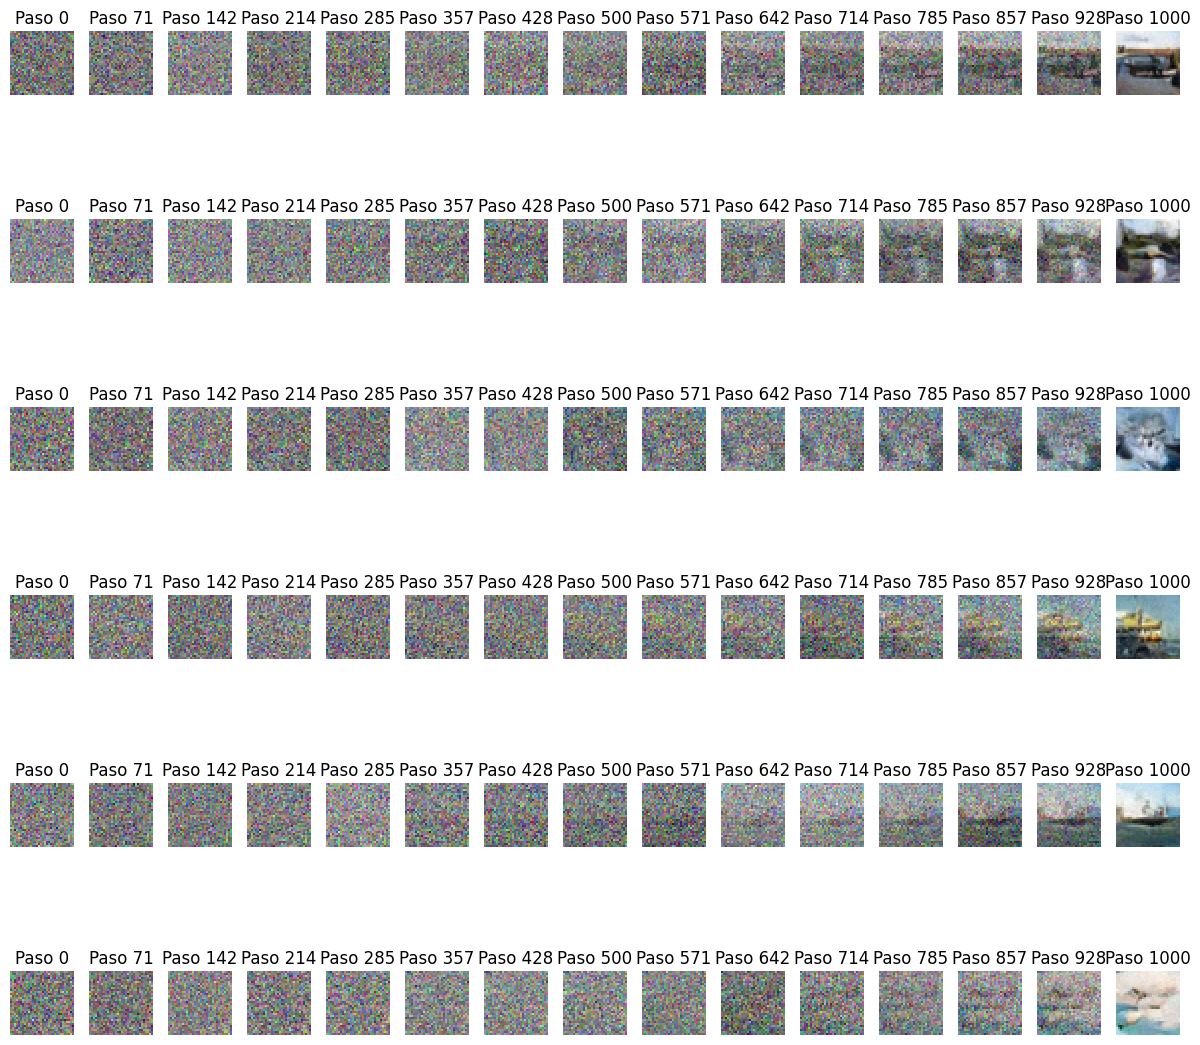

In [ ]:
if final_samples is not None:
    num_images_to_show = final_samples.shape[0] # Mostrar todas las imágenes del batch
    num_steps_in_trajectory = final_samples.shape[-1]

    # Seleccionar algunos pasos intermedios para mostrar
    steps_to_plot = np.linspace(0, num_steps_in_trajectory - 1, num=15, dtype=int)

    fig, axs = plot_image_evolution_pc(
        images=final_samples,
        n_images=num_images_to_show,
        n_intermediate_steps=steps_to_plot,
        figsize=(12, 2 * num_images_to_show) # Ajustar tamaño
    )
    if fig: # Comprobar si la figura se creó
        plt.show()

### Imagenes finales Generadas

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

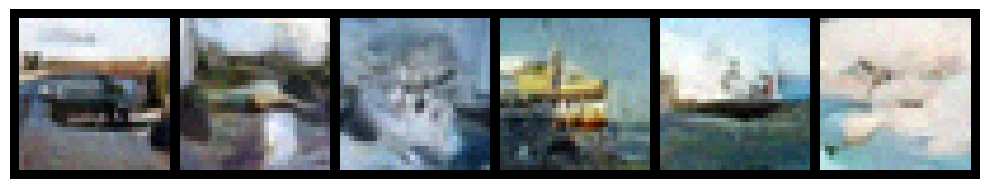

In [ ]:
plot_image_grid_color(final_samples[...,-1], figsize=(10,8), n_cols=num_images_to_show, n_rows=1)

# Ejemplos de Imagenes Generadas

Generacion de **10 imagenes de Barco** con **SUB-VP**:

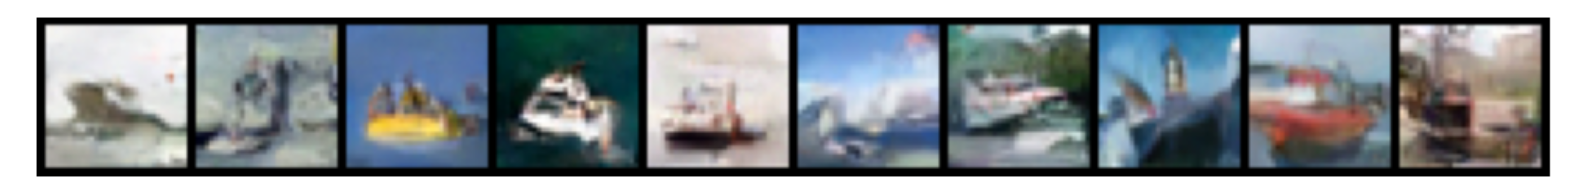

Generacion de **10 imagenes de Barco** con **VP**:

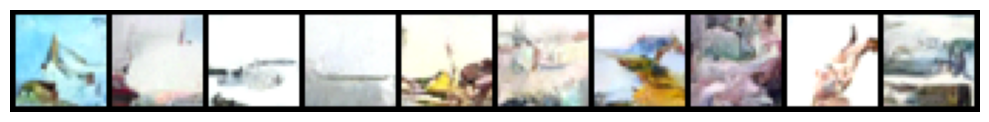

Generacion de **10 imagenes de Barco** con **VE**:

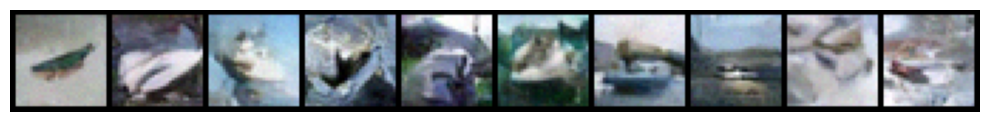